In [1]:
import pandas as pd
import numpy as np
from make_df import create_df, make_inputs #Custom module here
from naive import naive_fit, get_true_labels #Custom module here
import matplotlib.pyplot as plt

This is a demo of our Hard EM algorithm for survival analysis datasets
with a latent cured subpopulation. We will apply this to a melanoma data set.

STEP 1: DATA PREPARATION

In [2]:
mel = pd.read_csv('melanoma.csv')

In [3]:
mel.head()

,Unnamed: 0,time,status,sex,age,year,thickness,ulcer
0,1,10,3,1,76,1972,6.76,1
1,2,30,3,1,56,1968,0.65,0
2,3,35,2,1,41,1977,1.34,0
3,4,99,3,0,71,1968,2.90,0
4,5,185,1,1,52,1965,12.08,1


For the status column 1 means died from the disease, 2 means alive at then end of study, and 3 means died from unrelated
causes. Use this to make a censoring column as follows:
    
    1 means not censored (label 1)
    2 means censored (label 0)
    3 means cenosred (label 0)

In [4]:
censoring_indicator = mel['status'] 

In [5]:
censoring_indicator = censoring_indicator.replace(3, 0)

In [6]:
censoring_indicator = censoring_indicator.replace(2, 0)

In [7]:
mel['status'] = censoring_indicator

In [8]:
mel.head() #Sanity check

,Unnamed: 0,time,status,sex,age,year,thickness,ulcer
0,1,10,0,1,76,1972,6.76,1
1,2,30,0,1,56,1968,0.65,0
2,3,35,0,1,41,1977,1.34,0
3,4,99,0,0,71,1968,2.90,0
4,5,185,1,1,52,1965,12.08,1


In [9]:
covariates = ['sex', 'age', 'thickness', 'ulcer'] #Omit time, year, and status

In [30]:
time = mel['time']

In [10]:
mel_covariates = mel[covariates] 

In [11]:
#Now standardize the dataframe column wise 

mel_covariates = 1/mel_covariates.std()*(mel_covariates-mel_covariates.mean()) 

In [12]:
mel_covariates['status'] = censoring_indicator 
#add back the censoring indicator column

In [13]:
mel_covariates.head() #Sanity check

,sex,age,thickness,ulcer,status
0,1.259824,1.411768,1.297595,1.127628,0
1,1.259824,0.212131,-0.766989,-0.882491,0
2,1.259824,-0.687597,-0.533837,-0.882491,0
3,-0.789890,1.111859,-0.006709,-0.882491,0
4,1.259824,-0.027796,3.095237,1.127628,1


In [14]:
noncensored_proportion = len(mel_covariates[mel_covariates.status==1].index)/len(mel_covariates.index)

noncensored_proportion 
#This is the fraction of our dataset which is *not* censored.

0.2780487804878049

In [15]:
#Extract censored inputs (status label 0) and noncensored inputs 
#(status label 1) using our own function 

columns = ['status']

censored_inputs = make_inputs(mel_covariates, 0, columns) #extract censored

noncensored_inputs = make_inputs(mel_covariates, 1, columns) 
#extract noncensored

STEP 2: FEED INTO CUSTOM ALGORITHM

Now that the data has been prepared we can fit it into my algorithm.

In [16]:
fit = naive_fit(censored_inputs, noncensored_inputs, 'use_HardEM')  

In [17]:
y_pred = fit['pred'] #predicted label of the corresponding row 
        
y_scores = fit['prob'] #This is the probability of *not* being cured
    

    

In [18]:
censored_mel = mel_covariates[mel_covariates['status']==0]

noncensored_mel = mel_covariates[mel_covariates['status']==1]

In [19]:
censored_mel.head()

,sex,age,thickness,ulcer,status
0,1.259824,1.411768,1.297595,1.127628,0
1,1.259824,0.212131,-0.766989,-0.882491,0
2,1.259824,-0.687597,-0.533837,-0.882491,0
3,-0.789890,1.111859,-0.006709,-0.882491,0
7,-0.789890,0.452058,0.101420,1.127628,0


In [20]:
final = pd.concat([censored_mel, noncensored_mel]) 

final['predicted_cure_label'] = y_pred

final['predicted_prob'] = y_scores

In [21]:
cured = final[final.predicted_cure_label==0]

not_cured = final[final.predicted_cure_label==1]


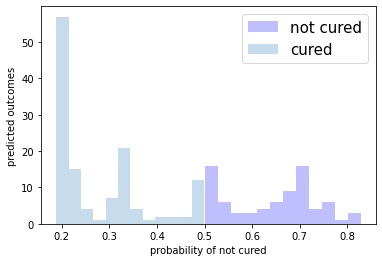

In [22]:
#We plot the predicted cured (not cured) labels on y-axis and 
#the probability of not being cured on the x-axis.


plt.xlabel('probability of not cured')
plt.ylabel('predicted outcomes')

plt.hist(not_cured['predicted_prob'], bins=12, label='not cured', color='blue', alpha=0.25)
plt.hist(cured['predicted_prob'], bins=12, label='cured', alpha=0.25)
plt.legend(fontsize=15)

plt.show()

In [23]:
y_scores.mean()

0.4146340747855795

In [24]:
y_pred.mean()

0.375609756097561

In [29]:
censored_inputs

array([[ 1.        ,  1.25982401,  1.41176781,  1.29759545,  1.12762792],
       [ 1.        ,  1.25982401,  0.21213091, -0.76698946, -0.88249141],
       [ 1.        ,  1.25982401, -0.68759676, -0.53383666, -0.88249141],
       [ 1.        , -0.78988966,  1.11185858, -0.0067086 , -0.88249141],
       [ 1.        , -0.78988966,  0.45205829,  0.10142023,  1.12762792],
       [ 1.        , -0.78988966,  0.69198567, -0.93256174,  1.12762792],
       [ 1.        ,  1.25982401,  1.17184043,  3.25743055,  1.12762792],
       [ 1.        , -0.78988966,  2.01158625,  1.89906208,  1.12762792],
       [ 1.        ,  1.25982401,  0.69198567, -0.55073179, -0.88249141],
       [ 1.        ,  1.25982401,  1.23182227, -0.55073179, -0.88249141],
       [ 1.        ,  1.25982401,  0.63200383,  1.84499767,  1.12762792],
       [ 1.        , -0.78988966,  0.9918949 , -0.3310951 , -0.88249141],
       [ 1.        , -0.78988966,  1.47174965, -0.93256174, -0.88249141],
       [ 1.        , -0.78988966,  1.4